In [1]:
# Load and inspect the data
library(tidyverse)
library(tidymodels)

players <- read_csv("https://raw.githubusercontent.com/achan919/dsci-final-project/refs/heads/main/players.csv")

head(players)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


# Title

#### Predictive Modelling of Play Time in Minecraft Servers

# Introduction
A research group is collecting data about how people play video games. They have set up a MineCraft server, and players’ actions are recorded as they navigate through the world. For running this project, they need to target their recruitment efforts, and make sure they have enough resources to handle the number of players they attract. The purpose of our project is to provide an idea for this and use data analysis to prove whether this idea can effectively assist their recruitment.

Understanding how different player characteristics relate to gameplay experience is essential for designing engaging game environments and tailoring content to different player groups. In behavioral game analytics, experience level is often used as a proxy for proficiency, engagement, or familiarity with game mechanics. Identifying factors that correlate with experience level can help inform game balancing, player retention strategies, and the design of personalized player experiences.

In this project, we analyze player information and gameplay behaviour using two data sources: a player dataset containing demographic variables and a session dataset containing gameplay durations. Our research question is:

**Can a player's gender and experience level be used to predict their total play time?**

To answer this question, we examine whether a player’s gender and experience level are related to their average play time . By summarizing and visualizing these variables, we aim to identify patterns in how experienece and gender differ across experience groups.

# Data Description
The file `players.csv` was collected by a research group in Computer Science at UBC to help us complete our project. It contains 196 players’ information and 7 variables columns:

| Variable     |Data Type | Description |
|--------------|----------|-------------|
| experience   | chr |Level of experience (Pro, Veteran, Amateur, Regular, Beginner) |
| subscribe    | lgl |Whether the player subscribed to the newsletter |
| hashedEmail  | chr | Hashed/hidden email of the player |
| played_hours | dbl |Total hours played (mean = 5.846) |
| name         | chr |Player's first name |
| gender       | chr |Gender (Male, Female, Non-binary, Prefer not to say, Agender, Two-Spirited, Other) |
| Age          | dbl |Player age in years (mean = 21.14) |

# Methods & Results

### **1. Wrangling + Cleaning**

The players table contains demographic and experience-related attributes describing each user. Variables such as experience and gender are categorical. To ensure proper treatment in grouping, plotting, or modeling, these fields were converted into factor types using **as_factor()**.

In [2]:
#Tidy players data
players_tidy <- players |>
  mutate(
    experience = as_factor(experience),
    gender = as_factor(gender)
  )
head(players_tidy)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


For the player data set, we also need to compute the mean of each numeric variable. This helps identify and compare the overall trends in player attributes such as age and playtime and give us a sense of what the data looks like before doing more analysis.

In [3]:
# Calculate players mean
player_means <- players_tidy |>
  summarize(across(where(is.numeric), mean, na.rm = TRUE)) |>
  pivot_longer(cols = everything(),
               names_to = "Variable",
               values_to = "Mean")
player_means

# Gender distribution
players_tidy |>
  count(gender)

# Experience distribution
players_tidy |>
  count(experience)

# Summary of player dataset
players_summarized <- summary(players)
players_summarized

Warning message:
“There was 1 warning in `summarize()`.
ℹ In argument: `across(where(is.numeric), mean, na.rm = TRUE)`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))”


Variable,Mean
<chr>,<dbl>
played_hours,5.845918
Age,21.139175


gender,n
<fct>,<int>
Male,124
Female,37
Non-binary,15
Prefer not to say,11
Agender,2
Two-Spirited,6
Other,1


experience,n
<fct>,<int>
Pro,14
Veteran,48
Amateur,63
Regular,36
Beginner,35


  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:196         Length:196         Min.   : 9.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :21.14  
                                       3rd Qu.:22.75  
                                       Max.   :58.00  
                               

### **2. Exploratory Data Analysis**

In [4]:
# Summary of average play time (hours) by experience group
play_time_experience <- players_tidy |>
  group_by(experience) |>
  summarise(avg_play_time = mean(played_hours, na.rm = TRUE),
           median_play_time = median(played_hours, na.rm = TRUE))
head(play_time_experience)

# Summary of gender by experience group
play_time_gender <- players_tidy |>
  group_by(gender) |>
  summarise(avg_play_time = mean(played_hours, na.rm = TRUE),
           median_play_time = median(played_hours, na.rm = TRUE))
head(play_time_gender)

# Summary of experience group by gender and play time
play_time_combined <- players_tidy |>
  group_by(experience, gender) |>
  summarise(avg_play_time = mean(played_hours, na.rm = TRUE)) |>
  arrange(experience, gender)
head(play_time_combined)

experience,avg_play_time,median_play_time
<fct>,<dbl>,<dbl>
Pro,2.6000000,0.3
Veteran,0.6479167,0.1
Amateur,6.0174603,0.1
Regular,18.2083333,0.1
Beginner,1.2485714,0.1


gender,avg_play_time,median_play_time
<fct>,<dbl>,<dbl>
Male,4.12741935,0.10
Female,10.63513514,0.10
Non-binary,14.88000000,0.00
Prefer not to say,0.37272727,0.00
Agender,6.25000000,6.25
Two-Spirited,0.08333333,0.00


`summarise()` has grouped output by 'experience'. You can override using the
`.groups` argument.


experience,gender,avg_play_time
<fct>,<fct>,<dbl>
Pro,Male,3.2909091
Pro,Non-binary,0.0000000
Pro,Other,0.2000000
Veteran,Male,0.2870968
Veteran,Female,0.8800000
Veteran,Non-binary,0.4875000


### **3. Visualizations**

#### Visualization 1: Gender Distribution 

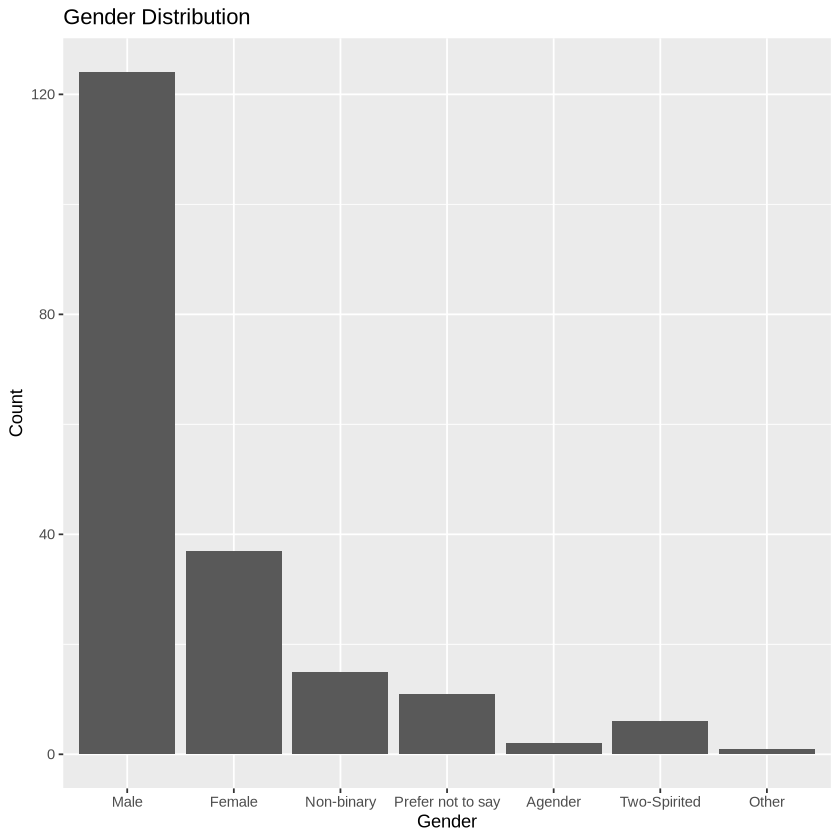

In [5]:
# visualization of gender distribution
gender_distribution_plot <- players_tidy |>
  ggplot(aes(x = gender)) +
  geom_bar() +
  labs(title = "Gender Distribution",
       x = "Gender",
       y = "Count")
gender_distribution_plot

 #### Visualization 2: Experience Distribution

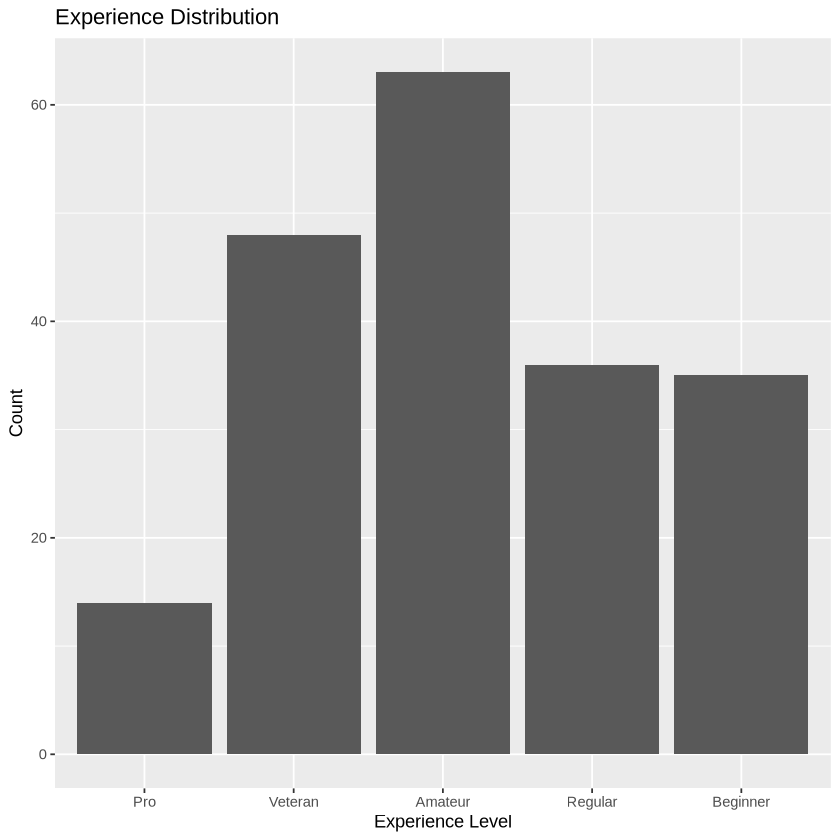

In [6]:
# visualization of experience distribution
experience_distribution_plot <- players_tidy |>
  ggplot(aes(x = experience)) +
  geom_bar() +
  labs(title = "Experience Distribution",
       x = "Experience Level",
       y = "Count")
experience_distribution_plot

#### Visualization 3: An Average Player's Play Time By Experience

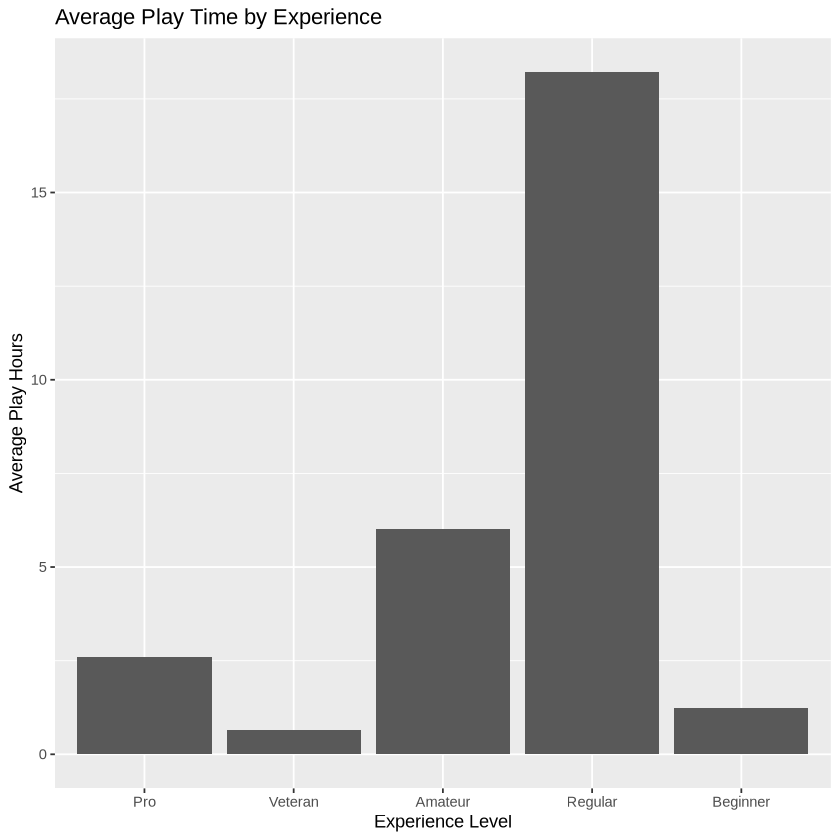

In [7]:
playtime_experience_plot <- ggplot(play_time_experience, aes(x = experience, y = avg_play_time)) +
  geom_bar(stat = "identity") +
  labs(title = "Average Play Time by Experience",
       x = "Experience Level",
       y = "Average Play Hours")
playtime_experience_plot

#### Visualization 4: An Average Player's Play Time by Gender

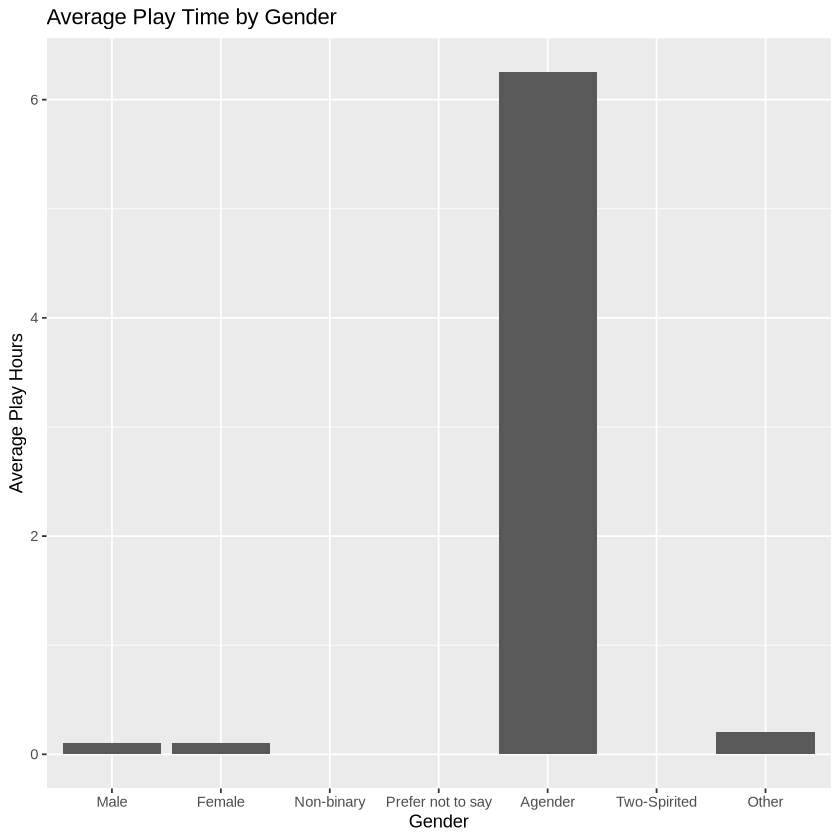

In [8]:
playtime_gender_plot <- ggplot(play_time_gender, aes(x = gender, y = median_play_time)) +
  geom_bar(stat = "identity") +
  labs(title = "Average Play Time by Gender",
       x = "Gender",
       y = "Average Play Hours")
playtime_gender_plot

#### Visualization 5: Average Play Time by Experience and Gender

`summarise()` has grouped output by 'experience'. You can override using the
`.groups` argument.


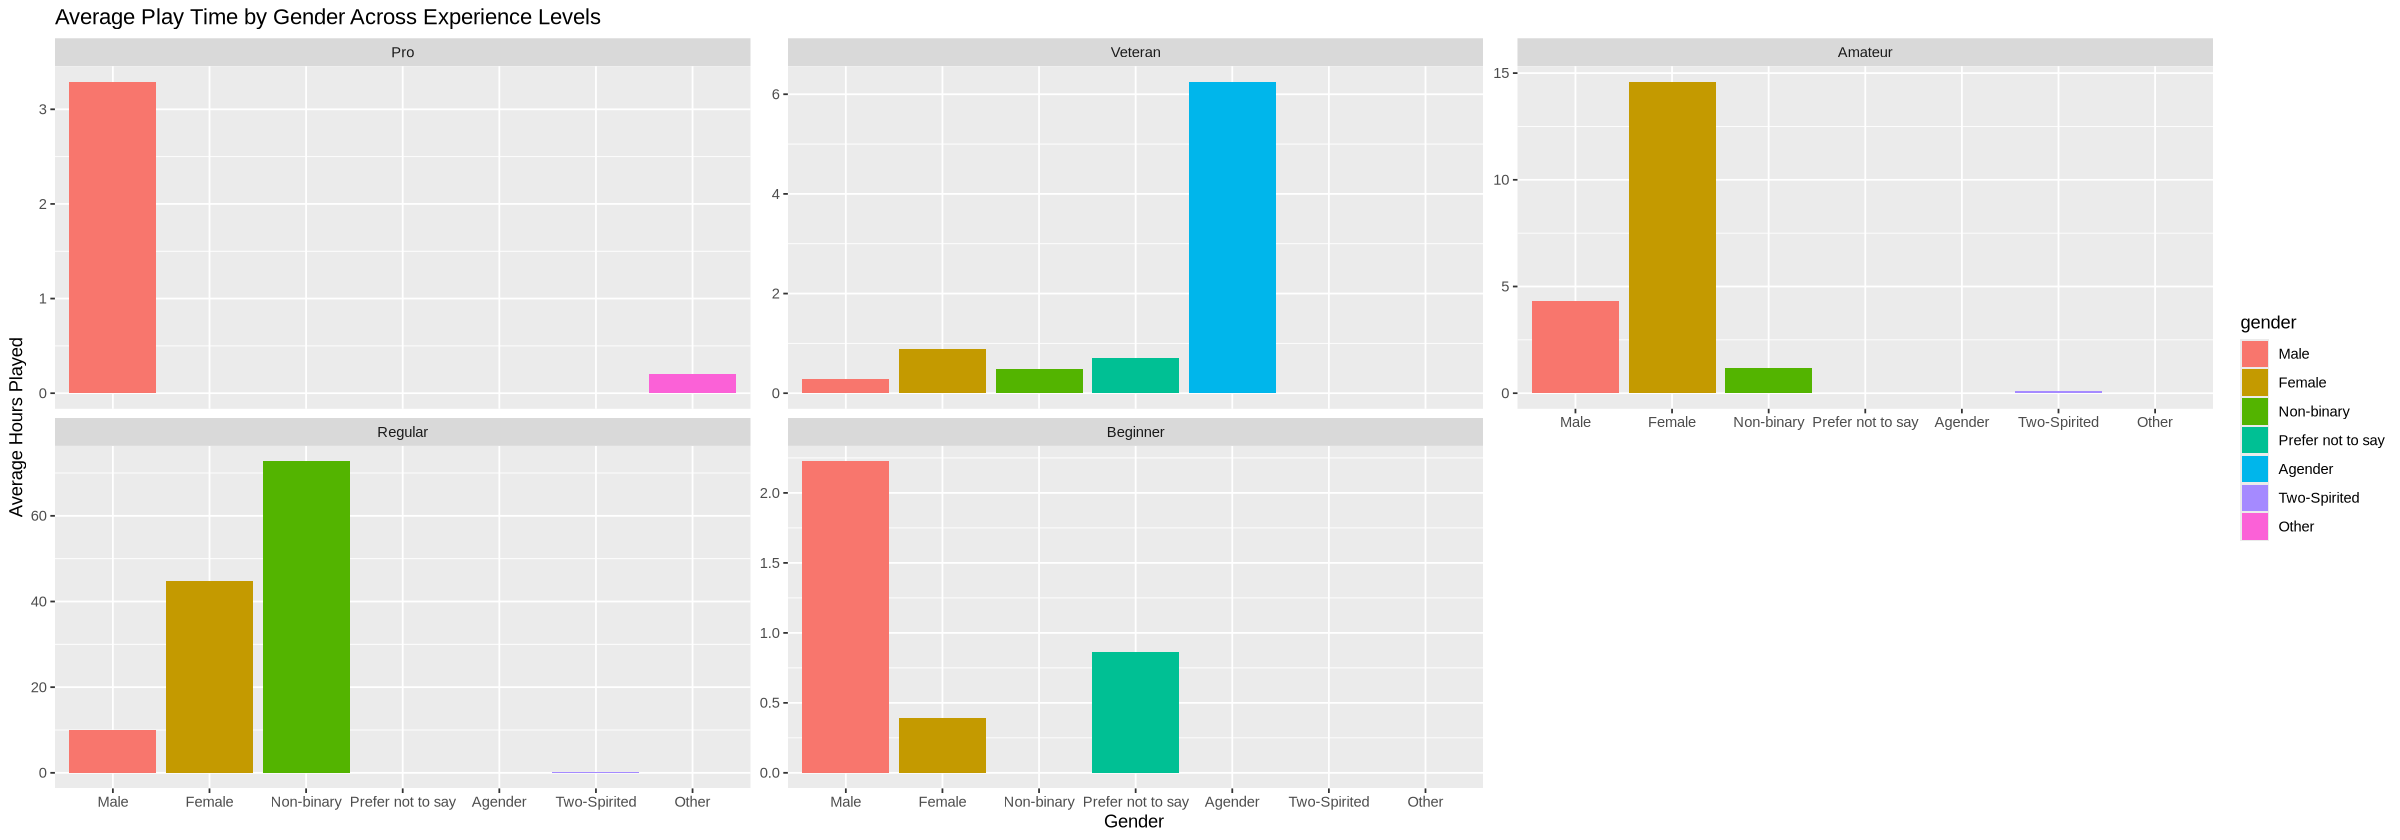

In [11]:
options(repr.plot.width = 20, repr.plot.height = 7)

experience_gender_facet <- players_tidy |>
  group_by(experience, gender) |>
  summarise(avg_play_time = mean(played_hours, na.rm = TRUE)) |>
  ggplot(aes(x = gender, y = avg_play_time, fill = gender)) +
  geom_bar(stat = "identity") +
  facet_wrap(~ experience, scales = "free_y") +
  labs(
    title = "Average Play Time by Gender Across Experience Levels",
    x = "Gender",
    y = "Average Hours Played"
  ) 
experience_gender_facet

# Discussion

Our analysis examined whether a player’s gender and total play time relate to their experience level. From the summary statistics and bar plot visualizations, we can see several patterns: 

The first visualization and second visualizations show distribution between gender and experience.

The third visualization shows that an average regular player has more play time than the rest, while an average veteran has the least.

The fourth visualization shows that an average non-binary player has more play time than the rest, while an an average two-spirited player has the least.

The final visualization shows that no single gender dominates gaming across all experience levels. Males lead in play time at the Pro and Beginner levels, while Agender, Female, and Non-binary individuals top the Veteran, Amateur, and Regular tiers respectively. This suggests that gaming engagement varies widely by gender and experience, with underrepresented identities showing strong participation in specific tiers.

Overall, our findings show that higher experience levels does not neccesarily associate with higher play time. On the contrary, regular players contribute the most amount of play time. Additionally, the gender distributions (Visualization 5) indicate that genders are not evenly represented across experience levels. For example, although non-binary players are not the majority of players, on average they spend more time playing than others. More detailed modeling would be required to investigate the relationship between gender and participation patterns more precisely.

# References